# Heart Disease Classification Using Deep Neural Networks and PyTorch

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
%matplotlib inline

In [34]:
data = pd.read_csv("/content/heart.csv")
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Step 1: Data Exploration

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    float64
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(5), int64(9)
memory usage: 33.3 KB


The dataset consists of 14 features, including "target" as the target variable. The target variable has a binary classification with 1=yes and 0=no. There are no missing values in the dataset, and therefore no need for imputation. All the variables have a numeric data type.

The classification goal is to predict whether the patient presents heart disease or not. High precision is desirable as false positive predictions would be costly or undesirable, such as unnecessary medical interventions or treatments. High recall is also important as false negatives (missed diagnosis) are costly or unacceptable, and high recall ensures that the model identifies as many cases of heart disease as possible.

Given the importance of both precision and recall in the context of predicting heart disease, the f1 score, the harmonic mean of precision and recall, will be looked into as it provides a single value that combines both measures.

In [73]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,3.030000e+02,303.000000,303.000000,3.030000e+02,3.030000e+02,303.000000,303.000000,3.030000e+02,303.000000,3.030000e+02,303.000000,303.000000,303.000000,303.000000
mean,4.690051e-17,0.683168,0.966997,-7.035077e-16,-1.113887e-16,0.148515,0.528053,-6.800574e-16,0.326733,2.345026e-17,1.399340,0.729373,2.313531,0.544554
std,1.001654e+00,0.466011,1.032052,1.001654e+00,1.001654e+00,0.356198,0.525860,1.001654e+00,0.469794,1.001654e+00,0.616226,1.022606,0.612277,0.498835
min,-2.797624e+00,0.000000,0.000000,-2.148802e+00,-2.324160e+00,0.000000,0.000000,-3.439267e+00,0.000000,-8.968617e-01,0.000000,0.000000,0.000000,0.000000
25%,-7.572802e-01,0.000000,0.000000,-6.638668e-01,-6.814943e-01,0.000000,0.000000,-7.061105e-01,0.000000,-8.968617e-01,1.000000,0.000000,2.000000,0.000000
50%,6.988599e-02,1.000000,1.000000,-9.273778e-02,-1.210553e-01,0.000000,1.000000,1.466343e-01,0.000000,-2.067053e-01,1.000000,0.000000,2.000000,1.000000
75%,7.316189e-01,1.000000,2.000000,4.783913e-01,5.456738e-01,0.000000,1.000000,7.151309e-01,1.000000,4.834512e-01,2.000000,1.000000,3.000000,1.000000
max,2.496240e+00,1.000000,3.000000,3.905165e+00,6.140401e+00,1.000000,2.000000,2.289429e+00,1.000000,4.451851e+00,2.000000,4.000000,3.000000,1.000000


There is a mix of categorical and numerical features in the dataset. Since the categorical features have already been encoded into numerical format, they do not require label encoding during the pre-processing step.

In [74]:
# Feature Analysis to seperate features by type
numerical_features = []
categorical_features = []

for col in data.columns:
      if len(data[col].unique()) > 5:  # Using a threshold for considering a numerical feature
          numerical_features.append(col)
      else:
          categorical_features.append(col)

print(f"Numerical Features:{numerical_features}")
print(f"Categorical Features: {categorical_features}")

Numerical Features:['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
Categorical Features: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']


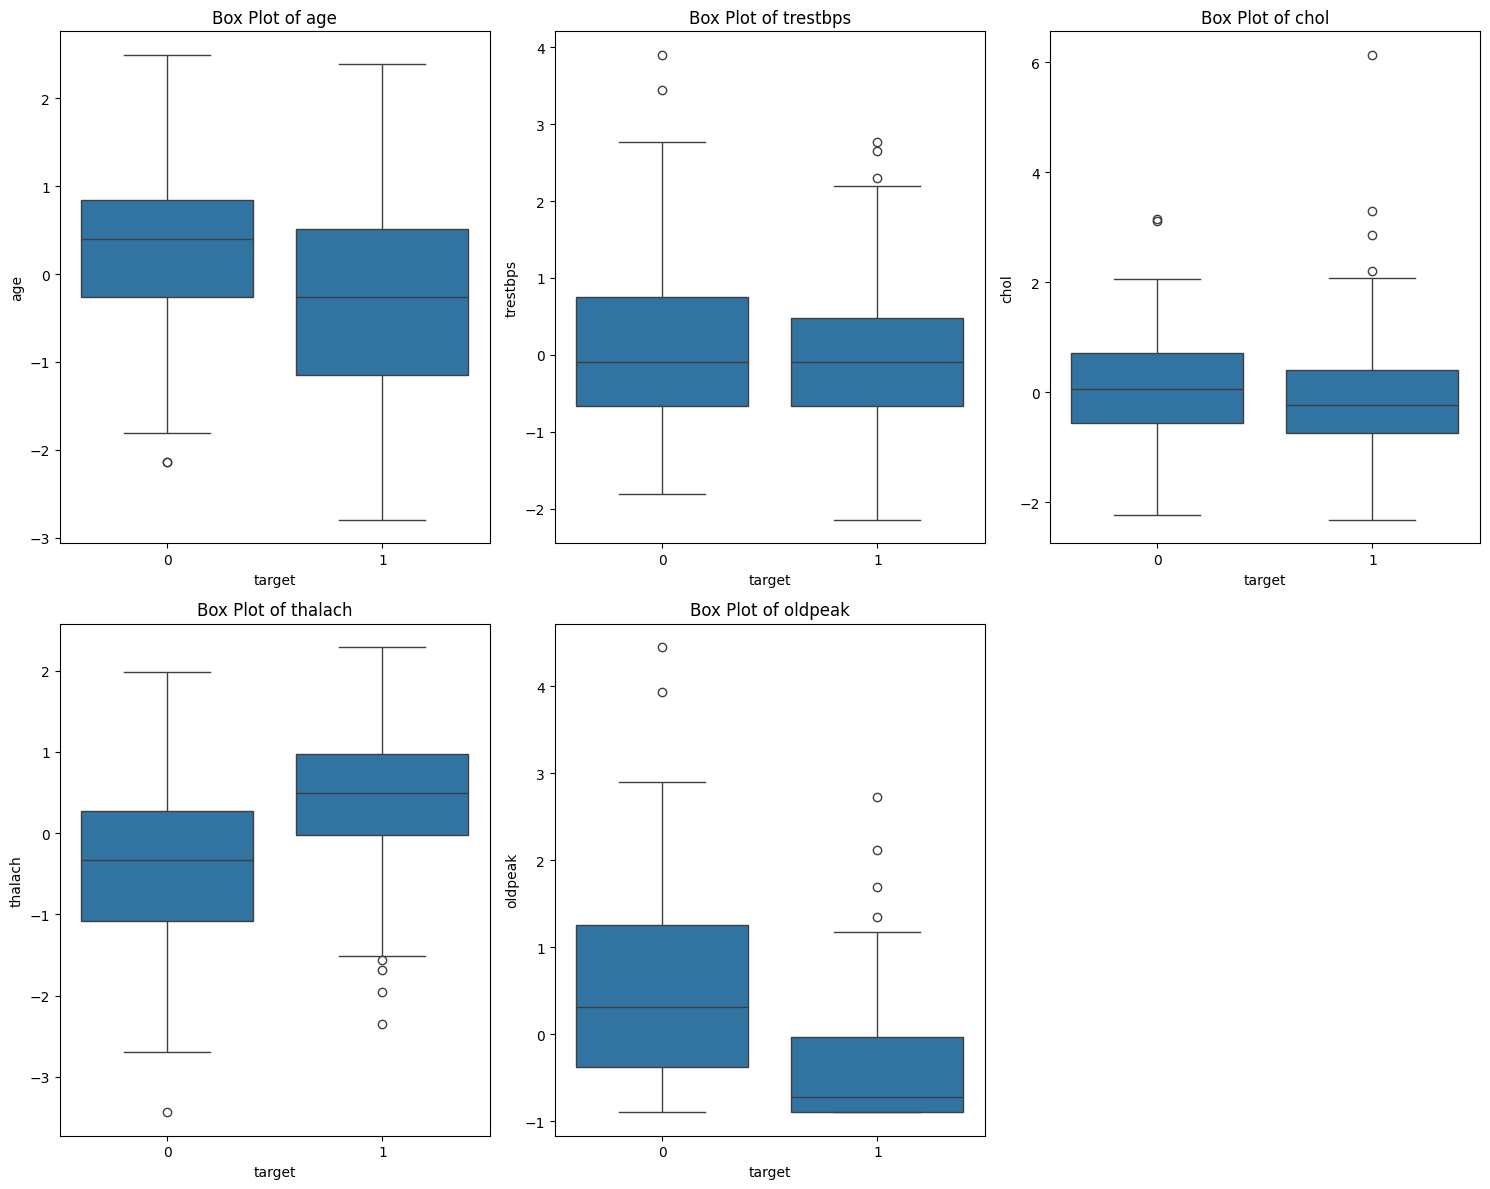

In [75]:
# Feature Visualization for numerical features to understand their distribution
fig, axes = plt.subplots(2,3, figsize=(15, 12))

for i, feature in enumerate(numerical_features):
    row = i // 3
    col = i % 3
    sns.boxplot(data = data, y = feature, x ='target', ax=axes[row, col])
    axes[row, col].set_title(f'Box Plot of {feature}')
    axes[row, col].set_xlabel('target')

# Hide any empty subplots
for i in range(len(numerical_features), 2 * 3):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

Box plots are used for understanding the central tendency, spread, and distributional characteristics of continuous variables, as well as identifying potential outliers and asymmetries in the data.

For example, we notice that 'oldpeak' has a skewed distribution. There are marked differences in the spread of the positive and negative target values for age, where people between 45-60 years are more likely to present positively. Also the positive group has a higher mean thalach value than the negative.

Also 'trestbps', 'chol' and 'oldpeak' have a few outliers. Because of the size of the dataset, it would be recommended to not drop the outlier datapoints as it would be challenging to train a neural network if the training set is too small.

If the decision is made to handle the outliers by data transformation or winsorization, testing the model's performance with and without outlier treatment as part of the sensitively analysis to ensure that the results are not overly influenced by outlier handling techniques.

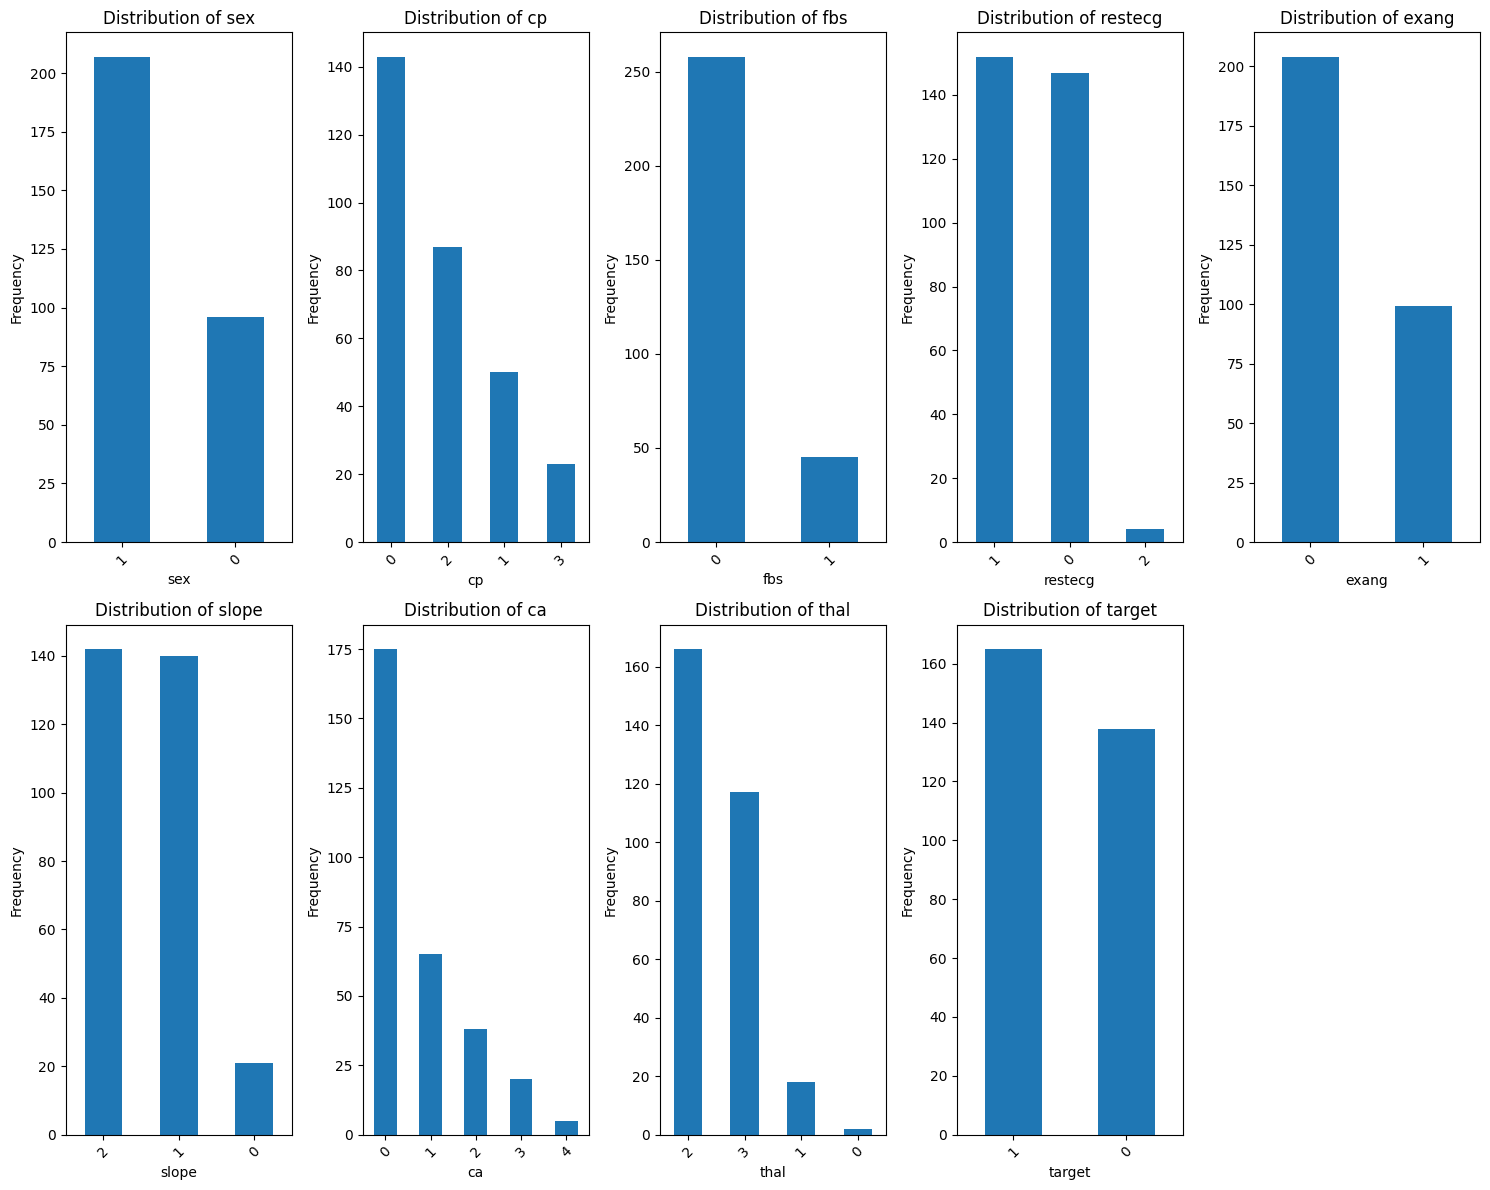

In [76]:
# Feature Visualization for categorical features to understand their distribution
fig, axes = plt.subplots(2,5, figsize=(15, 12))

for i, feature in enumerate(categorical_features):
    row = i // 5
    col = i % 5
    data[feature].value_counts().plot(kind='bar', ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {feature}')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].tick_params(axis='x', rotation=45)

# Hide any empty subplots
for i in range(len(categorical_features), 2 * 5):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

Attribute information provided for the categorical features is as follows:

- sex: 1 = male, 0 = female
- cp: Value 0: typical angina, Value 1: atypical angina, Value 2: non-anginal pain, Value 3: asymptomatic
- fbs:1 = true; 0 = false
- restecg: 0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria
- exang:1 = yes; 0 = no
- slope: Value 0: upsloping, Value 1: flat, Value 2: downsloping
- ca:0-4 major vessels
- thal: 0 = not measured; 1 = normal; 2 = fixed defect; 3 = reversable defect
- target: 0 = no, 1 = yes

Since there are several outliers in the numerical features, we will use random forest to quickly determine feature importance as it uses bootstrapping and multiple decision trees to make predictions and is therefore robust to outliers. Given the low dimensionality of the dataset, we will not be dropping features based on their importance, and will only consider it for exploring the data.

In [77]:
# Train a random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(data.drop(["target"],axis=1), data["target"])

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame to store feature importances
importance_df = pd.DataFrame({'Feature': data.drop(["target"],axis=1).columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the top features with highest importance
importance_df

,Feature,Importance
2,cp,0.135346
7,thalach,0.129879
11,ca,0.108091
12,thal,0.105813
9,oldpeak,0.102469
0,age,0.091921
4,chol,0.076270
3,trestbps,0.075079
8,exang,0.058675
10,slope,0.055157


If a dataset is imbalanced, oversampling, undersampling or synthetic data generation (bootstapping) can be performed to balance the classes and prevent the model from being biased towards the majority class. The dataset provided is well balanced as seen from the bar plot for the target variable and therefore this step can be skipped during pre-processing.

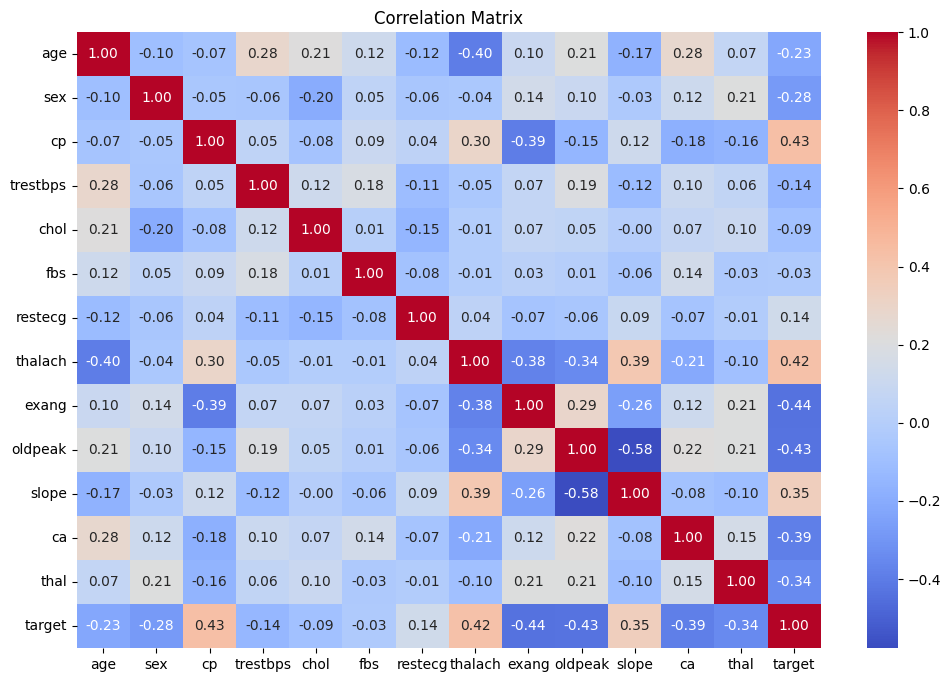

In [78]:
# Correlation Analysis
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


The plotting of a correlation matrix is a good way to explore correlations between features and the target variable and to compute correlations between numerical features to identify potentially redundant features.

From the matrix, we can see that 'cp' and 'thalach' have a high positive correlation with the target and 'exang' and 'oldpeak' have high negative correlations. Also 'fbs' seems to be minimally correlated to the target. These may provide medical professionals insights what causes patients to present heart disease and how it can be prevented.

Since no two features have a correlation of -/+ 1, it can be deduced that none of the features are redundant.

## Step 2: Data Preprocessing

Since neural networks are sensitive to the scale of input features, it's essential to scale numerical features to a similar range. Therefore as a pre-processing step, Z-score normalization (standardization) has been used to scales features to have a mean of 0 and a standard deviation of 1, in order to have a normal distribution in the features being scaled.

In [42]:
# Apply feature scaling only to numerical columns
ss = StandardScaler()
data[numerical_features] = ss.fit_transform(data[numerical_features])
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0.952197,1,3,0.763956,-0.256334,1,0,0.015443,0,1.087338,0,0,1,1
1,-1.915313,1,2,-0.092738,0.072199,0,1,1.633471,0,2.122573,0,0,2,1
2,-1.474158,0,1,-0.092738,-0.816773,0,0,0.977514,0,0.310912,2,0,2,1
3,0.180175,1,1,-0.663867,-0.198357,0,1,1.239897,0,-0.206705,2,0,2,1
4,0.290464,0,0,-0.663867,2.082050,0,1,0.583939,1,-0.379244,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,0.290464,0,0,0.478391,-0.101730,0,1,-1.165281,1,-0.724323,1,0,3,0
299,-1.033002,1,3,-1.234996,0.342756,0,1,-0.771706,0,0.138373,1,0,3,0
300,1.503641,1,0,0.706843,-1.029353,1,1,-0.378132,0,2.036303,1,2,3,0
301,0.290464,1,0,-0.092738,-2.227533,0,1,-1.515125,1,0.138373,1,1,3,0


Depending on the size and complexity of the dataset, feature selection or dimensionality reduction techniques like PCA are often performed during pre-processing to reduce the number of features while retaining most of the information, which can help improve the efficiency and performance of neural network models. Since we have a relatively low-dimensional dataset, this step can be skipped.

In [43]:
# Turn data into tensors in preparation of the neral network setup
X = torch.tensor(data.drop(["target"],axis=1).values).type(torch.float)
y = torch.tensor(data['target']).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.9522,  1.0000,  3.0000,  0.7640, -0.2563,  1.0000,  0.0000,  0.0154,
           0.0000,  1.0873,  0.0000,  0.0000,  1.0000],
         [-1.9153,  1.0000,  2.0000, -0.0927,  0.0722,  0.0000,  1.0000,  1.6335,
           0.0000,  2.1226,  0.0000,  0.0000,  2.0000],
         [-1.4742,  0.0000,  1.0000, -0.0927, -0.8168,  0.0000,  0.0000,  0.9775,
           0.0000,  0.3109,  2.0000,  0.0000,  2.0000],
         [ 0.1802,  1.0000,  1.0000, -0.6639, -0.1984,  0.0000,  1.0000,  1.2399,
           0.0000, -0.2067,  2.0000,  0.0000,  2.0000],
         [ 0.2905,  0.0000,  0.0000, -0.6639,  2.0820,  0.0000,  1.0000,  0.5839,
           1.0000, -0.3792,  2.0000,  0.0000,  2.0000]]),
 tensor([1., 1., 1., 1., 1.]))

In [44]:
# Splitting the data while ensuring that the split maintains the distribution of the target classes to avoid data leakage.
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=32, stratify=y)

## Step 3: Training a Neural Network Classifier model

In [45]:
# Define the neural network model
class HeartDiseaseModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, activation):
        super(HeartDiseaseModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.activation = activation
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(activation)
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(activation)
        layers.append(nn.Linear(hidden_size, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return torch.sigmoid(self.model(x))

# Function to train the model
def train_model(model, criterion, optimizer, train_loader, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        #print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Function to evaluate the model
def evaluate_model(model, test_loader):
 # Forward pass
    with torch.no_grad():
        outputs = model(X_test)

    # Calculate accuracy
    accuracy = metrics.accuracy_score(y_test, torch.round(outputs))
    precision = metrics.precision_score(y_test, torch.round(outputs))
    recall = metrics.recall_score(y_test, torch.round(outputs))
    f1 = metrics.f1_score(y_test, torch.round(outputs))
    auc = metrics.roc_auc_score(y_test, torch.round(outputs))
    #print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall: .4f}, f1: {f1:.4f}, AUC: {auc:.4f}' )
    return accuracy, precision, recall, f1, auc

## Step 4: Evaluating the learned model

Hyperparameter tuning is performed to optain the best model. Different architectures such as number of hidden layers (1, 2, 3), number of nodes in each layer (32, 64, 128) and different activation functions (ReLU, Sigmoid and LeakyReLU) are explored.


The learned model is evaluated in terms of different parameters such as accuracy, AUC, precision, and recall.

The F1 score, which is the harmonic mean of precision and recall, is also included in the metrics as it provides a single value that combines both measures.

In [46]:
# Define hyperparameter options
hidden_size_options = [32, 64, 128]
num_layers_options = [1, 2, 3]
activation_options = [nn.ReLU(), nn.Sigmoid(), nn.LeakyReLU()]

# Initialize an empty list to store results
results = []

# Loop through hyperparameter combinations
for hidden_size in hidden_size_options:
    for num_layers in num_layers_options:
        for activation in activation_options:
            model = HeartDiseaseModel(input_size=X_train.shape[1], hidden_size=hidden_size, num_layers=num_layers, activation=activation)
            criterion = nn.BCELoss()  # Use Binary Cross-Entropy Loss for binary classification
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
            test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64)
            train_model(model, criterion, optimizer, train_loader, num_epochs=100)
            accuracy, precision, recall, f1, auc = evaluate_model(model, test_loader)

            # Append results to the list
            results.append({'hidden_size': hidden_size, 'num_layers': num_layers, 'activation': type(activation).__name__, 'accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'f1': f1, 'AUC': auc})

# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(results)
results_df

,hidden_size,num_layers,activation,accuracy,Precision,Recall,f1,AUC
0,32,1,ReLU,0.857143,0.836364,0.92,0.876190,0.850244
1,32,1,Sigmoid,0.868132,0.851852,0.92,0.884615,0.862439
2,32,1,LeakyReLU,0.835165,0.830189,0.88,0.854369,0.830244
3,32,2,ReLU,0.835165,0.843137,0.86,0.851485,0.832439
4,32,2,Sigmoid,0.868132,0.851852,0.92,0.884615,0.862439
5,32,2,LeakyReLU,0.857143,0.836364,0.92,0.876190,0.850244
6,32,3,ReLU,0.769231,0.763636,0.84,0.800000,0.761463
7,32,3,Sigmoid,0.835165,0.843137,0.86,0.851485,0.832439
8,32,3,LeakyReLU,0.780220,0.788462,0.82,0.803922,0.775854
9,64,1,ReLU,0.846154,0.846154,0.88,0.862745,0.842439


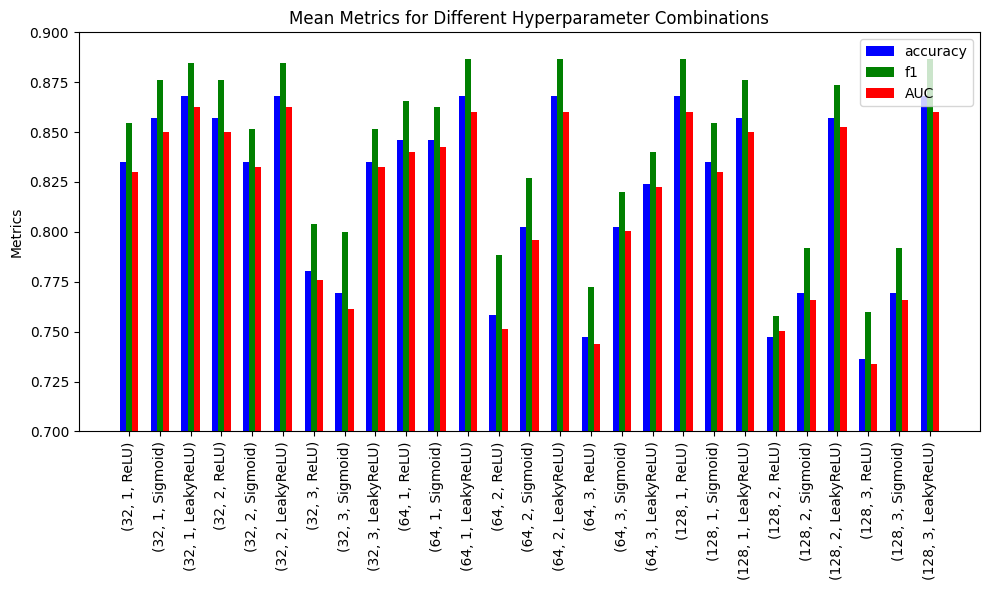

In [71]:
# Calculate mean metrics for each combination of hyperparameters
mean_metrics = results_df.groupby(['hidden_size', 'num_layers', 'activation']).mean().reset_index()

# Define hyperparameters
hidden_size_options = [32, 64, 128]
num_layers_options = [1, 2, 3]
activation_options = [type(activation).__name__ for activation in [nn.ReLU(), nn.Sigmoid(), nn.LeakyReLU()]]

# Create bar plots for mean metrics
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each metric
colors = ['blue', 'green', 'red']

# Define width of each bar
bar_width = 0.2

# Define x-axis positions for each group
x = np.arange(len(mean_metrics))

# Plot each metric with a grouped bar plot
for i, metric in enumerate(['accuracy', 'f1', 'AUC']):
    ax.bar(x + i * bar_width, mean_metrics[metric], width=bar_width, label=metric, color=colors[i])

# Set x-axis tick labels
ax.set_xticks(x + bar_width)
ax.set_xticklabels([f'({hidden_size}, {num_layers}, {activation})' for hidden_size in hidden_size_options for num_layers in num_layers_options for activation in activation_options], rotation=90)

# Set y-axis label and title
ax.set_ylabel('Metrics')
ax.set_title('Mean Metrics for Different Hyperparameter Combinations')
ax.set_ylim(0.7, 0.9)  # Set y-axis limits between 0.5 and 1

# Add legend
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


Based on highest accuracy, f1 and AUC scores, the best neural network model is determined to have the following hyperparameters:

- hidden_size = 64 -> this is the number of nodes in each layer
- num_layers = 2 -> this is the number of layers
- activation = Sigmoid -> this is the activation function

## Step 5: Parameter Sensitivity Analysis

Parameter sensitivity analysis is performed and the results of the sensitivity analysis are interpreted to draw conclusions about the impact of each parameter on the model's performance. This information can be used to make informed decisions about model selection, hyperparameter tuning, or further experimentation.

Accuracy will be used as the metric for the sensitivity evaluation.

In [47]:
# Define hyperparameter options
hidden_size_options = [32, 64, 128]
num_layers_options = [1, 2, 3]
activation_options = [nn.ReLU(), nn.Sigmoid(), nn.LeakyReLU()]
num_epochs_options = [50, 100, 200]

# Initialize an empty list to store results
results = []

# Loop through hyperparameter combinations
for num_epochs in num_epochs_options:
  for hidden_size in hidden_size_options:
      for num_layers in num_layers_options:
          for activation in activation_options:
              model = HeartDiseaseModel(input_size=X_train.shape[1], hidden_size=hidden_size, num_layers=num_layers, activation=activation)
              criterion = nn.BCELoss()  # Use Binary Cross-Entropy Loss for binary classification
              optimizer = optim.Adam(model.parameters(), lr=0.001)
              train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
              test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64)
              train_model(model, criterion, optimizer, train_loader, num_epochs=num_epochs)
              accuracy, precision, recall, f1, auc = evaluate_model(model, test_loader)

              # Append results to the list
              results.append({'hidden_size': hidden_size, 'num_layers': num_layers, 'activation': type(activation).__name__, 'num_epochs': num_epochs, 'accuracy': accuracy})

# Convert the list of dictionaries to a DataFrame
results_df1 = pd.DataFrame(results)

We will use heatmaps to provide a visual representation of the sensitivity of each parameter to changes in the evaluation metric i.e. accuracy. For easier interpretation,  num_epochs and hidden_size are plotted together as a single plot, followed by num_layers and activation function.

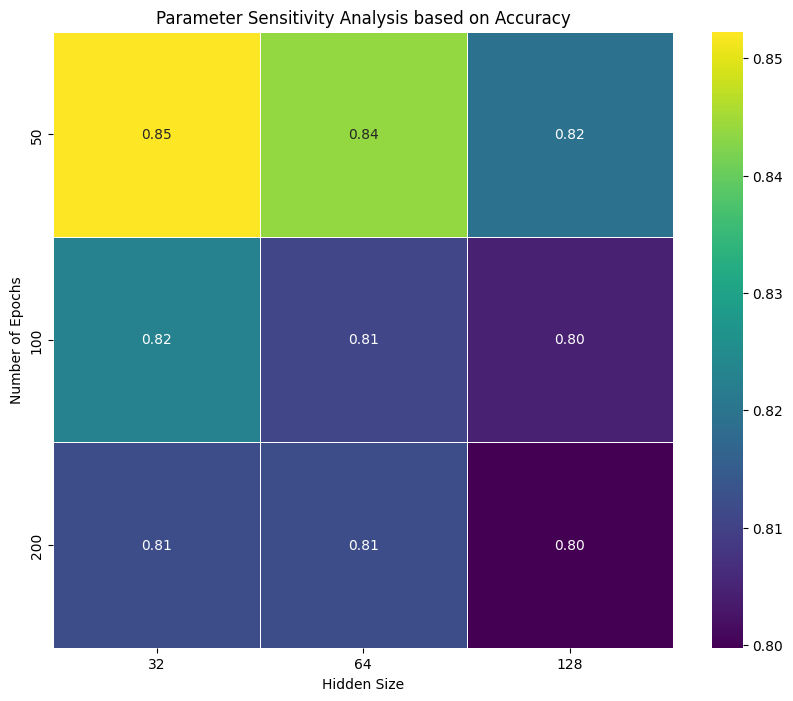

In [48]:
# Pivot the DataFrame to create a 2D representation suitable for a heatmap
heatmap_data = results_df1.pivot_table(index='num_epochs', columns='hidden_size', values='accuracy')

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Parameter Sensitivity Analysis based on Accuracy')
plt.xlabel('Hidden Size')
plt.ylabel('Number of Epochs')
plt.show()

**Change in number of nodes:** Based on the heatmap, it is observed that the lower the number of nodes, the higher the accuracy. The accuracy changes by 1-3% as the number of nodes changes from 32 to 128.

**Change in number of epochs:** Based on the heatmap, it is observed that the lower the number of nodes, the higher the accuracy. The accuracy changes by 2-4% as the number of epochs changes from 50 to 200.

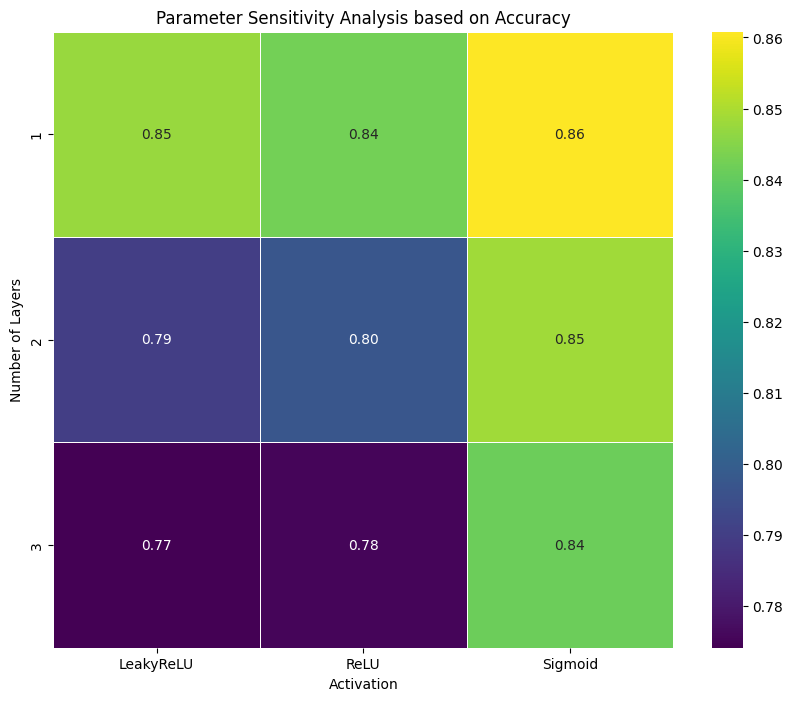

In [49]:
heatmap_data = results_df1.pivot_table(index='num_layers', columns='activation', values='accuracy')

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Parameter Sensitivity Analysis based on Accuracy')
plt.xlabel('Activation')
plt.ylabel('Number of Layers')
plt.show()

**Change in number of layers:** Based on the heatmap, it is observed that the lower the number of hidden layers, the higher the accuracy. The accuracy changes by 3-7% as the number of layers changes from 1 to 3.

**Activation function:** Based on the heatmap, it is observed that the sigmoid activation function has the highest accuracy, followed by the LeakyReLU and then ReLU.

## Step 6: Conclusion

It can be concluded that due to the smaller size of the dataset, a simpler architecture is better able to predict the classification goal as the data may not require the complexity introduced by larger architectures to capture the underlying patterns effectively. Smaller architectures are also less prone to overfitting than larger architectures, which is a problem often faced with small datasets. If a smaller architecture achieves better performance, it may imply that the larger architectures are overfitting to the training data, capturing noise rather than true patterns.

A good final step to conclude the parameter sensitivity analysis would be to validate the findings using additional datasets or cross-validation techniques to ensure the robustness of the conclusions.